# Predicting Which Passenger Survived the Titanic

This project is probably the rite of passage for everyone getting into data science. I never really enjoyed the movie, but the door could totally fit both Rose and Jack.

This project is binary classification problem, where the passenger either survived (`1`) or died (`0`). Here is a list of the columns of the dataset:

* `PassengerID` - Unique ID for each column
* `Survived` - Whether the passenger survived (`1`) or not (`0`)
* `Pclass` - Class of the passenger's ticket. Either 1, 2 or 3.
* `Sex` - Passenger's sex (male or female)
* `Age` - Passenger's age
* `Sibsp` - Number of sibling or spouses aboard the Titanic
* `Parch` - Number of parents or children aboard the Titanic
* `Ticket` - Passenger's ticket number
* `Fare` - The price paid for the passenger's ticket
* `Cabin` - Passenger's cabin number
* `Embarked` - Port where the passenger embarked. Can be:
    * `C` - Cherbourg
    * `Q` - Queenstown
    * `S` - Southampton

Although we know exactly who survived the Titanic, the project is still useful to apply important concepts in data science and machine learning. So here it is!

**Objective:** Predict which passenger survived the Titanic (Jack died)

**Techniques used:**
* Pandas, matplotlib, numpy
* Scikit-learn
* Logistic regression, cross-validation, k-nearest neighbours
* Regular expressions
* Heatmap
* Recursive feature elimination
* Hyperparameter optimization
* Grid search
* Random forest classifier

## Introduce the test and train dataset

In [1]:
import pandas as pd

test = pd.read_csv("test.csv")
test_shape = test.shape

train = pd.read_csv('train.csv')
train_shape = train.shape

train_shape

(891, 12)

## Preliminary exploration of survival rate

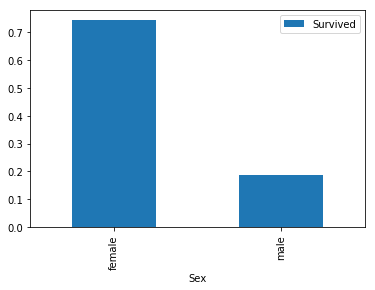

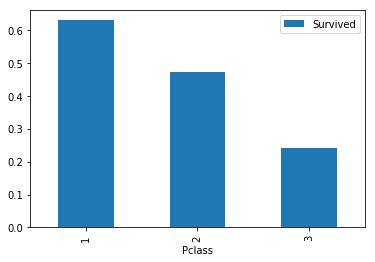

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()

pclass_pivot = train.pivot_table(index = 'Pclass', values = 'Survived')
pclass_pivot.plot.bar()
plt.show()

It seems that female and people from in 1st class have a better chance to survive.

## Turn age into a category

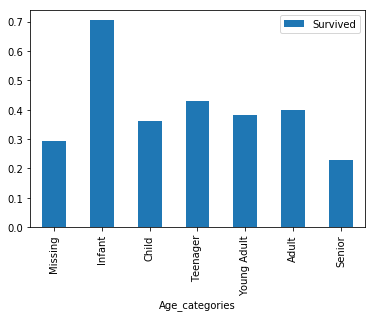

In [4]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()
plt.show()

Using categories for age, we see that infants are more likely to survive.

## Create dummies

In [5]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")

train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")

train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")

## Logistic regression

In [6]:
holdout = test # from now on we will refer to this dataframe as the holdout data

from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(all_X, all_y, test_size = 0.2, random_state = 0)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
print(accuracy)

0.8100558659217877


## Cross-validation to avoid overfitting

In [9]:
from sklearn.model_selection import cross_val_score
import numpy as np

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv = 10)
accuracy = np.mean(scores)
print(accuracy)

0.8024670865963002


Submitting this model to Kaggle resulted in **75.6%** accuracy. 

## Feature selection

Now, we will try other features in order to improve the accuracy score.

In [10]:
from sklearn.preprocessing import minmax_scale
# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

train['Embarked'] = train['Embarked'].fillna('S')
holdout['Embarked'] = holdout['Embarked'].fillna('S')

train = create_dummies(train, 'Embarked')
holdout = create_dummies(holdout, 'Embarked')

cols = ['SibSp', 'Parch', 'Fare']

for col in cols:
    train[col + "_scaled"] = minmax_scale(train[col])
    holdout[col + "_scaled"] = minmax_scale(holdout[col])

C:\Users\marco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


## Assess feature relevance

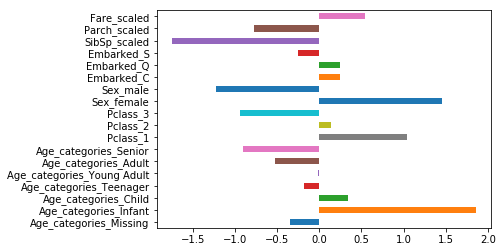

In [12]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

lr = LogisticRegression()
lr.fit(train[columns], train['Survived'])
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], index = train[columns].columns)

feature_importance.plot.barh()
plt.show()

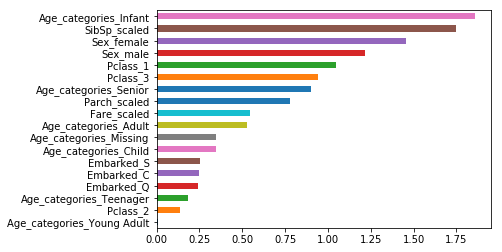

In [13]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

Using the absolute value and ordering them gives us a better overview of each fearure's relevance. Let's work with the top 8.

In [14]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv = 10)
accuracy = np.mean(scores)
print(accuracy) 

0.8148019521053229


Notice the small increase in accuracy here.

Submitting this model to Kaggle resulted in an accuracy score of **77%**, an improvement of roughly 2%!

## Feature binning on *fare*

In [15]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df,cut_points,label_names):
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

cut_points = [0,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]

train = process_fare(train,cut_points,label_names)
holdout = process_fare(holdout,cut_points,label_names)

train = create_dummies(train,"Fare_categories")
holdout = create_dummies(holdout,"Fare_categories")

## Create dummies for *Title* and *Cabin*

In [16]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)

holdout_extracted_titles = holdout['Name'].str.extract(' ([A-Za-z]+)\.', expand = False)
holdout['Title'] = holdout_extracted_titles.map(titles)

train['Cabin_type'] = train['Cabin'].str[0]
train['Cabin_type'] = train['Cabin_type'].fillna('Unknown')

holdout['Cabin_type'] = holdout['Cabin'].str[0]
holdout['Cabin_type'] = holdout['Cabin_type'].fillna('Unknown')

for col in ['Title', 'Cabin_type']:
    train = create_dummies(train, col)
    holdout = create_dummies(holdout, col)

## Generate a heatmap for collinearity

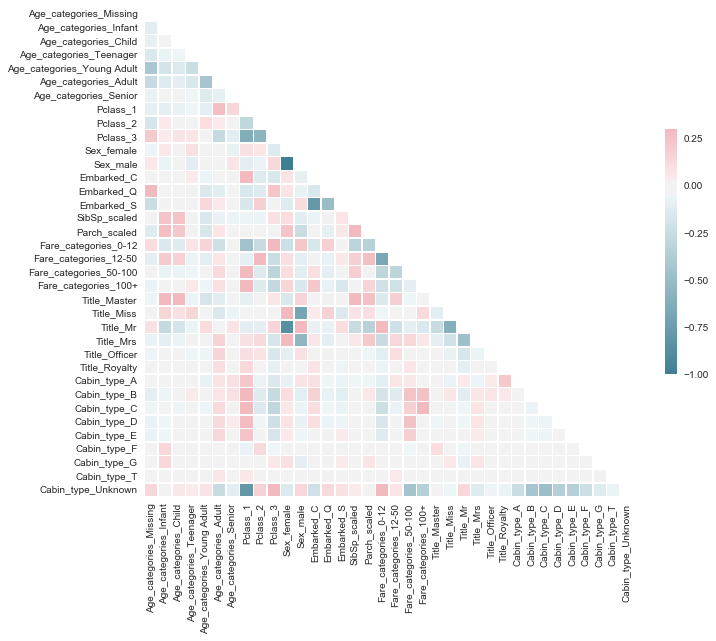

In [17]:
import seaborn as sns

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

plot_correlation_heatmap(train[columns])

## Use recursive feature elimination with cross-validation

In [22]:
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]

lr = LogisticRegression()
selector = RFECV(lr, cv = 10)
selector.fit(all_X, all_y)

optimized_columns = all_X.columns[selector.support_]

all_X = train[optimized_columns]
all_y = train["Survived"]

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv = 10)
accuracy = np.mean(scores)

print(accuracy)

0.8226549199863807


Submitting this model to Kaggle resulted in an accuracy score of **78%**.

## Model selection and tuning

In [23]:
import pandas as pd

train = pd.read_csv('train_modified.csv')
holdout = pd.read_csv('holdout_modified.csv')

### Logistic regression accuracy score

In [24]:
all_X = train.drop(['Survived','PassengerId'],axis=1)
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv = 10)
accuracy_lr = scores.mean()

print(accuracy_lr)

0.823891442515038


### K-nearest neighbours accuracy score

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 1)
scores = cross_val_score(knn, all_X, all_y, cv = 10)
accuracy_knn = scores.mean()

print(accuracy_knn)

0.7857382816933379


### Hyperparameter optimization on k-nearest neighbours

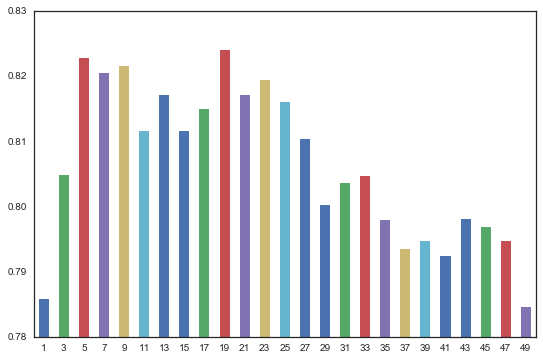

In [26]:
def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),
                                   ylim=(0.78,0.83),rot=0)
    plt.show()

knn_scores = dict()

for k in range(1, 50, 2):
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, all_X, all_y, cv = 10)
    accuracy_knn = scores.mean()
    knn_scores[k] = accuracy_knn
    
plot_dict(knn_scores)

A *k* value of 19 yields the best result.

### Use grid search for model selection

In [28]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = hyperparameters, cv = 10)
grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_params)
print(best_score)

{'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.8282828282828283


Submitting the top performing model to Kaggle resulted in an accuracy score of **75.6%** which is less than the previous submission.

### Random forest classifier score

In [29]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state = 1)
scores = cross_val_score(clf, all_X, all_y, cv = 10)
accuracy_rf = scores.mean()

print(accuracy_rf)

0.8070125411417546


In [30]:
clf = RandomForestClassifier(random_state = 1)

hyperparameters = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [5, 10],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [3, 5],
    'n_estimators': [6, 9]
}

grid = GridSearchCV(clf, param_grid = hyperparameters, cv = 10)
grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_params)
print(best_score)

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}
0.8428731762065096


Submitting this model to Kaggle resulted in an accuracy score of **77.1%**, which is better than the k-nearest neighbour model, but less accurate than the logistic regression.